In [1]:
from datetime import date, timedelta
import geopandas, pandas as pd
from constants import *
from download import download
from geo import convert_df
from phe import plot_areas, recent_phe_data_summed, map_data as phe_map_data, plot_map as phe_plot_map
from zoe import latest_map_data as zoe_map_data, bokeh_plot_map as zoe_plot_map, add_simple_geoms
from plotting import matplotlib_zoe_vs_phe_map, geoplot_bokeh, save_to_disk, bokeh_zoe_vs_phe_map
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
force_download = False
for_date = date.today()-timedelta(days=0)

In [3]:
# download cases data
suffix = 'csv'
for type_ in 'cases', 'deaths':
    path = base_path / f'coronavirus-cases_{for_date}.{suffix}'
    if force_download or not path.exists():
        download(cases_url.format(data_type=suffix), path)

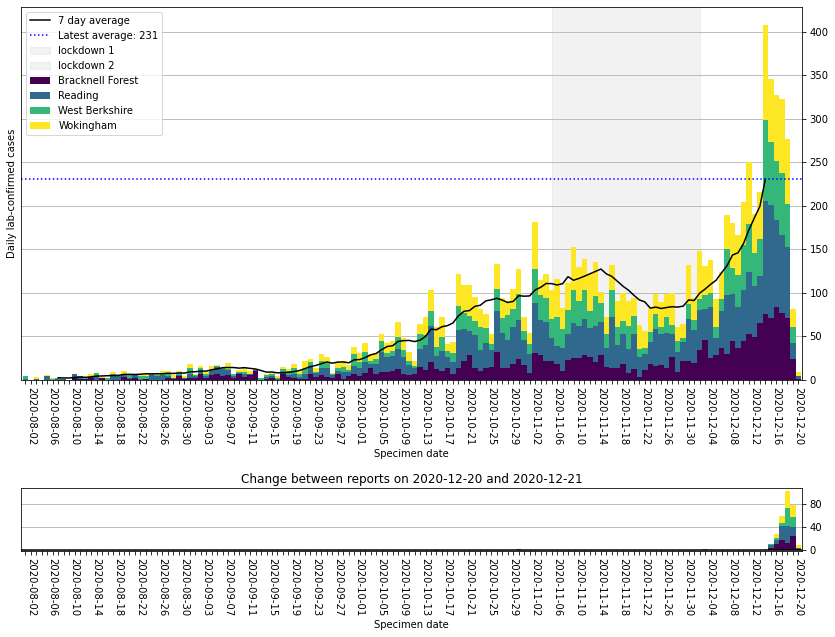

In [3]:
plot_areas(for_date, areas=my_areas, uncertain_days=5, earliest=second_wave)

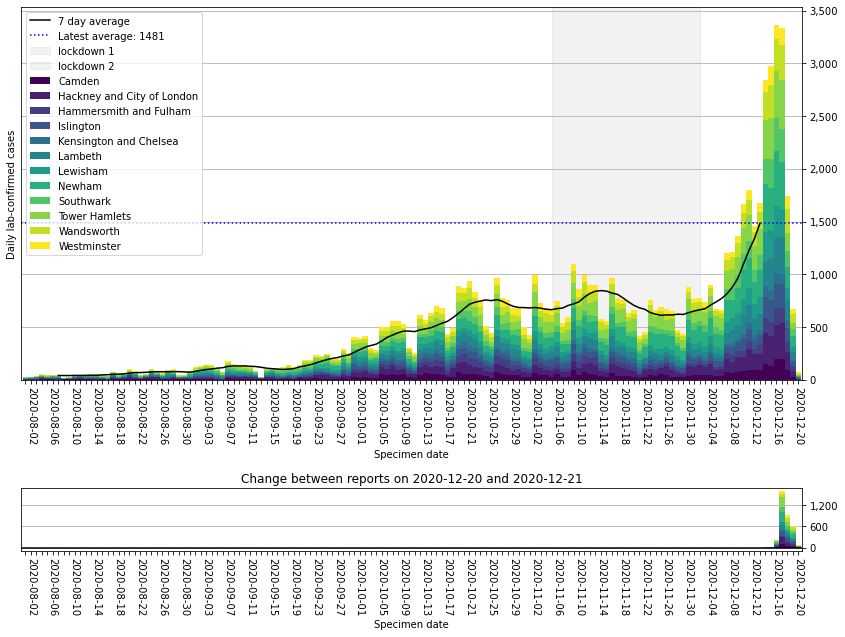

In [4]:
plot_areas(for_date, areas=london_areas, uncertain_days=6, earliest=second_wave)

In [5]:
top_10_types = ltla
data = recent_phe_data_summed(for_date, by=top_10_types)
top_10 = data.sort_values(per100k, ascending=False)[:10][[area,per100k,cases,specimen_date]]
top_10

,Area name,"cases per 100,000 people",Daily lab-confirmed cases,Specimen date
Area code,,,,
E06000034,Thurrock,1025.938270,1770.0,2020-12-20
E07000072,Epping Forest,957.776981,1256.0,2020-12-20
E07000068,Brentwood,949.706074,727.0,2020-12-20
E09000016,Havering,917.730111,2366.0,2020-12-20
E07000066,Basildon,916.809246,1704.0,2020-12-20
E07000069,Castle Point,873.764850,787.0,2020-12-20
E07000075,Rochford,838.114071,729.0,2020-12-20
E06000035,Medway,826.690180,2297.0,2020-12-20
E09000026,Redbridge,795.766444,2418.0,2020-12-20


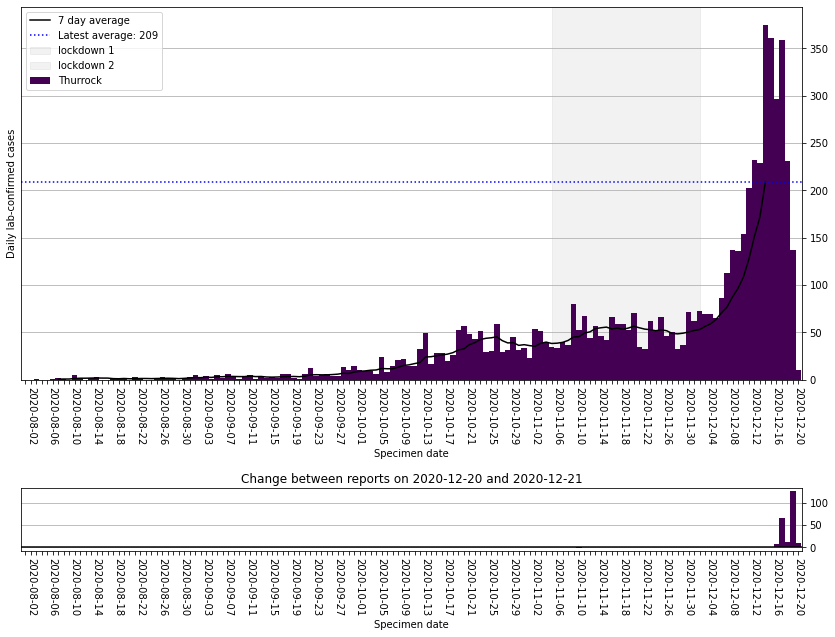

In [6]:
plot_areas(for_date, areas = [top_10.iloc[0].name], area_types=top_10_types, uncertain_days=5, earliest=second_wave)

In [7]:
top_10_types = ltla
data = recent_phe_data_summed(for_date, by=top_10_types)
top_10 = data.sort_values(cases, ascending=False)[:10][[area,per100k,cases,specimen_date]]
top_10

,Area name,"cases per 100,000 people",Daily lab-confirmed cases,Specimen date
Area code,,,,
E08000025,Birmingham,212.287997,2423.0,2020-12-20
E09000026,Redbridge,795.766444,2418.0,2020-12-20
E09000016,Havering,917.730111,2366.0,2020-12-20
E06000035,Medway,826.690180,2297.0,2020-12-20
E09000025,Newham,610.502692,2149.0,2020-12-20
E09000010,Enfield,597.539754,1995.0,2020-12-20
E09000030,Tower Hamlets,598.353819,1901.0,2020-12-20
E09000008,Croydon,465.815138,1795.0,2020-12-20
E09000031,Waltham Forest,647.271413,1791.0,2020-12-20


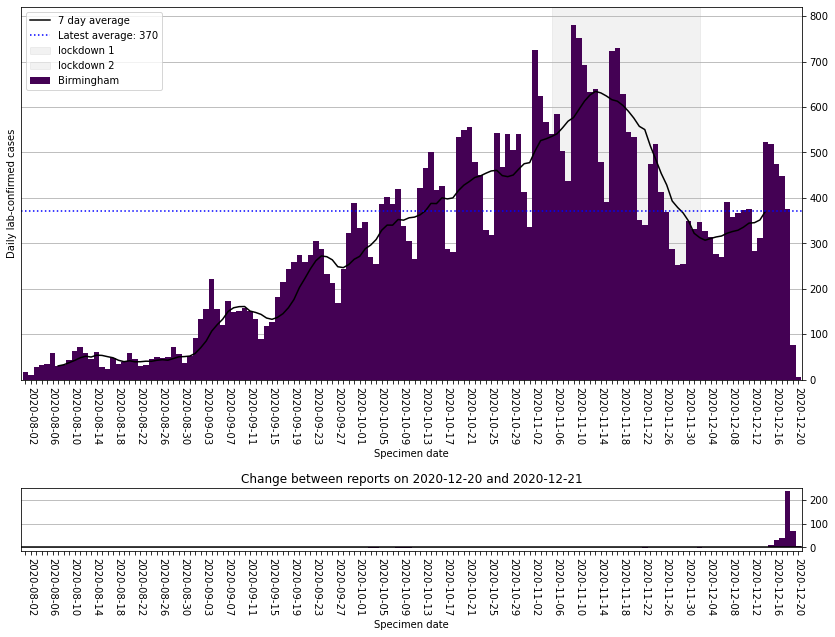

In [8]:
plot_areas(for_date, areas = [top_10.iloc[0].name], area_types=top_10_types, uncertain_days=5, earliest=second_wave)

In [9]:
zoe_date, zoe_df = zoe_map_data()

In [10]:
phe_recent_date, phe_recent_geo = phe_map_data(for_date)
phe_recent_title = (
    'PHE lab-confirmed cases summed over last ' 
    f"{int(phe_recent_geo['recent_days'].iloc[0])} days to {phe_recent_date:%d %b %Y}"
)

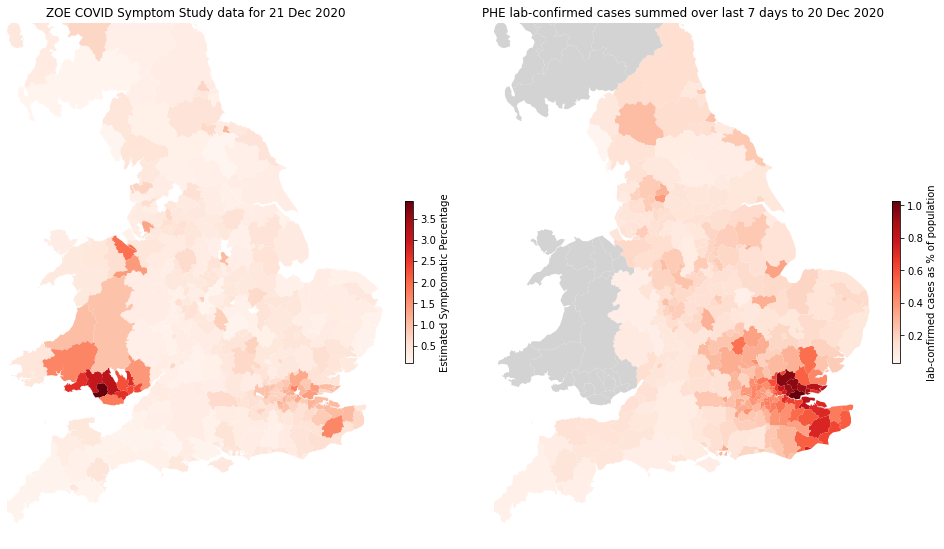

In [11]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)   

In [12]:
zoe_new_lad16 = add_simple_geoms(zoe_df)

In [13]:
bokeh_zoe_vs_phe_map(zoe_new_lad16, zoe_date, phe_recent_geo, phe_recent_title)

Loading BokehJS ...

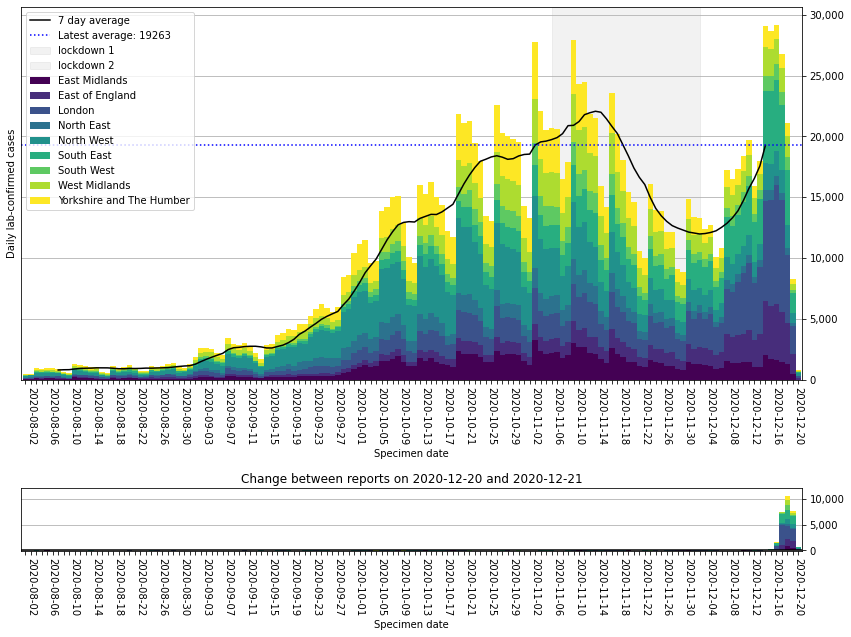

In [17]:
from functools import partial
from phe import plot_with_diff, data_for_date
plot_with_diff(
    for_date-timedelta(days=0),
    partial(data_for_date, area_types=region),
    uncertain_days=5, 
    diff_days=1,
    diff_log_scale=False,
    diff_ylims=[-10, 12_000],
    earliest=second_wave
)